**With exceptions of SQL queries to CartoDB for Raw Data and Clustering Analysis, all other work/code originated by Francis Ko**

****Import Modules****

In [1]:
import os
import csv
import json
import ast
import shapefile
import urllib
import urllib2
import geopy
import shapely
import pandas as pd
import numpy as np
import fiona
import geopandas as gp
import scipy as sp
import statsmodels.api as sm
import gdal
import shapely
import scipy.stats as sp
import matplotlib.pylab as plt
import sklearn as km
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from shapely.geometry import Polygon, Point, MultiPoint
from descartes import PolygonPatch
from cStringIO import StringIO
from geopandas import GeoDataFrame
from fiona.crs import from_epsg

%matplotlib inline

****Define SQL Query for the following desired datasets:****

- Top 5 medical facilities for asthma-related cases

- NYC hospital inpatient 2013 discharge information

- NYC highway streets per ZIP code

In [2]:
SQL_SOURCE = 'https://fb55.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

**Facility Query**

In [3]:
facilityQuery = '''
SELECT *
FROM nyc_facilities
'''
facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
facilities     = gp.GeoDataFrame.from_features(facilityData['features'])
facilities = facilities.sort(['facility_id'], ascending=[1])
facilities.head(5)

C:\Users\fbk\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,cartodb_id,cooperator_address,cooperator_address_2,cooperator_city,cooperator_name,cooperator_state,cooperator_zip_code,description,facility_address_1,facility_address_2,...,operator_address_1,operator_address_2,operator_city,operator_name,operator_state,operator_zip_code,ownership_type,regional_office,regional_office_id,short_description
38,44,,,,,New York,NaN,Hospital Extension Clinic,129 Beach 19 St,,...,393 Front St,,Hempstead,Episcopal Health Services Inc,New York,11550,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,HOSP-EC
39,136,,,,,New York,NaN,Residential Health Care Facility - SNF,2749 Linden Blvd,,...,2749 Linden Boulevard,,Brooklyn,Brooklyn-Queens Nursing Home Inc,New York,11208,Business Corporation,Metropolitan Area Regional Office - New York City,5,NH
7,142,,,,,New York,NaN,Diagnostic and Treatment Center,42-09 28th Street,,...,250 Church Street,,New York,City of New York,New York,10013,Municipality,Metropolitan Area Regional Office - New York City,5,DTC
40,156,111 East 210th Street,,Bronx,Montefiore Medical Center,New York,10467.0,Hospital Extension Clinic,One Fordham Plaza,,...,111 East 210th Street,,Bronx,"Montefiore Health System, Inc",New York,10467,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,HOSP-EC
41,165,,,,,New York,NaN,Hospital Extension Clinic,211-221 Powell Street,,...,127 S Broadway,,Yonkers,St Joseph Hospital Inc,New York,10701,Not for Profit Corporation,Metropolitan Area Regional Office - New York City,5,HOSP-EC


In [4]:
'''
The result in the cell below gives us the unique number of medical facilities
in NYC, we need to merge the dataset with the discharges one to find the top 
five hospitals for asthma-related admissions.
'''
facilities['facility_id'].count()

1275

**Asthma Discharges Query**

In [5]:
dischargeQuery = '''
SELECT *
FROM nyc_discharge_2012
'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
discharge       = pd.read_csv(dischargeStream)
discharge = discharge.loc[discharge['ccs_diagnosis_description'] == 'ASTHMA']
discharge = discharge.sort(['facility_id'], ascending=[1])
discharge.head()

C:\Users\fbk\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,cartodb_id,the_geom,the_geom_webmercator,field_1,health_service_area,hospital_county,operating_certificate_number,facility_id,facility_name,ccs_diagnosis_code,ccs_diagnosis_description,ccs_procedure_code,ccs_procedure_description,apr_drg_code
18,9795,NaN,NaN,9794,New York City,Bronx,7000002,1165,Jacobi Medical Center,128,ASTHMA,0,NO PROC,141
21427,19151,NaN,NaN,19150,New York City,Bronx,7000002,1165,Jacobi Medical Center,128,ASTHMA,217,OTHER RESP THERAPY,141
21415,19139,NaN,NaN,19138,New York City,Bronx,7000002,1165,Jacobi Medical Center,128,ASTHMA,0,NO PROC,141
21406,19130,NaN,NaN,19129,New York City,Bronx,7000002,1165,Jacobi Medical Center,128,ASTHMA,217,OTHER RESP THERAPY,141
21335,19055,NaN,NaN,19054,New York City,Bronx,7000002,1165,Jacobi Medical Center,128,ASTHMA,217,OTHER RESP THERAPY,141


In [6]:
'''
The result below gives us the number of patients in 2012 that were 
discharged from all NYC hospitals after being treated for asthma.
'''
discharge['facility_id'].count()

20048

In [7]:
'''
The result below gives us the unique IDs of facilities in 2012 
that treated patients for asthma.
'''
discharge['facility_id'].unique()

array([1165, 1168, 1169, 1172, 1175, 1176, 1178, 1185, 1186, 1286, 1288,
       1293, 1294, 1301, 1302, 1304, 1305, 1306, 1309, 1315, 1318, 1320,
       1324, 1626, 1628, 1629, 1630, 1632, 1633, 1635, 1637, 1638, 1639,
       1692, 1737, 1738, 1740, 3058, 3376], dtype=int64)

In [8]:
'''
This output gives us the five facilities with the highest number
of patients discharged for asthma.
'''
df_discharge_count = discharge['facility_id'].value_counts(
        normalize=False, sort=True, ascending=False, bins=None, dropna=True
        )
df_discharge_count.head()

1169    1930
1172    1698
1318    1156
1301    1091
1178    1072
Name: facility_id, dtype: int64

**NYC ZIP Code Query**

In [9]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcodes      = gp.GeoDataFrame.from_features(zipcodeData['features'])
zipcodes      = zipcodes.sort(['zipcode'], ascending=[1])
zipcodes.crs  = from_epsg(2263)
zipcodes = zipcodes[['zipcode', 'geometry', 'highway_length']]
zipcodes.head(5)

C:\Users\fbk\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,zipcode,geometry,highway_length
15,10001,"(POLYGON ((-73.999352 40.74733, -74.000399 40....",4.853261
115,10002,"(POLYGON ((-73.97702 40.711649, -73.977141 40....",5.163702
148,10003,"(POLYGON ((-73.981562 40.732643, -73.982022 40...",0.000000
199,10004,"(POLYGON ((-74.02213 40.684541, -74.022385 40....",8.692550
123,10005,"(POLYGON ((-74.008269 40.707722, -74.008645 40...",4.475026


In [10]:
zipcodes['geometry'].head(1)

15    (POLYGON ((-73.999352 40.74733, -74.000399 40....
Name: geometry, dtype: object

In [11]:
zipcodes['zipcode'].count()

200

**The two cells below will output the top five medical facilities
for asthma-related cases and their ZIP Codes.**

In [12]:
facilities_top = facilities.loc[facilities.facility_id.isin([1169, 1172, 1318, 1301, 1178])]

**TASK 1 STEP 1 Complete: Display List of Top-5 Medical Facilities for Asthma-related cases**

In [13]:
facilities_top['zipcode'] = facilities_top['facility_zip_code']
facilities_top_merged     = pd.merge(facilities_top, zipcodes, left_on=['zipcode'],
                                     right_on=['zipcode'],
                                     how='inner')
facilities_top_merged     = facilities_top_merged[['facility_name', 'zipcode', 
                                               'geometry_y', 'highway_length']]

facilities_top_merged['geometry'] = facilities_top_merged['geometry_y']
facilities_top_merged.drop('geometry_y', axis=1, inplace=True)
facilities_top_merged[['facility_name']]

C:\Users\fbk\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,facility_name
0,Montefiore Medical Center - Henry & Lucy Moses...
1,Lincoln Medical & Mental Health Center
2,Bronx-Lebanon Hospital Center - Concourse Divi...
3,Kings County Hospital Center
4,Wyckoff Heights Medical Center


In [14]:
zipcodes_t5     = gp.GeoDataFrame(zipcodes)
zipcodes_t5.crs = from_epsg(2263)
#zipcodes_t5_1 = zipcodes_t5
zipcodes_t5.head()

,zipcode,geometry,highway_length
15,10001,"(POLYGON ((-73.999352 40.74733, -74.000399 40....",4.853261
115,10002,"(POLYGON ((-73.97702 40.711649, -73.977141 40....",5.163702
148,10003,"(POLYGON ((-73.981562 40.732643, -73.982022 40...",0.000000
199,10004,"(POLYGON ((-74.02213 40.684541, -74.022385 40....",8.692550
123,10005,"(POLYGON ((-74.008269 40.707722, -74.008645 40...",4.475026


**TASK 2 STEP 1 COMPLETE: Create Dataframe listing Top-5 Facilities for Asthma-related Admittances with ZIP Codes and Highway-Mileage per ZIP**

In [15]:
facilities_top_geom  = facilities_top_merged[['facility_name', 
                                             'geometry', 'zipcode', 
                                              'highway_length']]
facilities_shape     = gp.GeoDataFrame(facilities_top_geom)
facilities_shape.crs = from_epsg(2263)
facilities_shape.head()

,facility_name,geometry,zipcode,highway_length
0,Montefiore Medical Center - Henry & Lucy Moses...,"(POLYGON ((-73.863293 40.89529, -73.862875 40....",10467,19.172015
1,Lincoln Medical & Mental Health Center,"(POLYGON ((-73.931681 40.807955, -73.931704 40...",10451,7.914185
2,Bronx-Lebanon Hospital Center - Concourse Divi...,"(POLYGON ((-73.897516 40.856183, -73.896533000...",10457,5.017199
3,Kings County Hospital Center,"(POLYGON ((-73.942503 40.638965, -73.943986 40...",11203,2.212840
4,Wyckoff Heights Medical Center,"(POLYGON ((-73.93204400000001 40.702002, -73.9...",11237,0.000000


**TASK 1 STEP 2 COMPLETE: Plot map of ZIP Codes containing Top-5 Medical Facilities for Asthma-related Admittances**

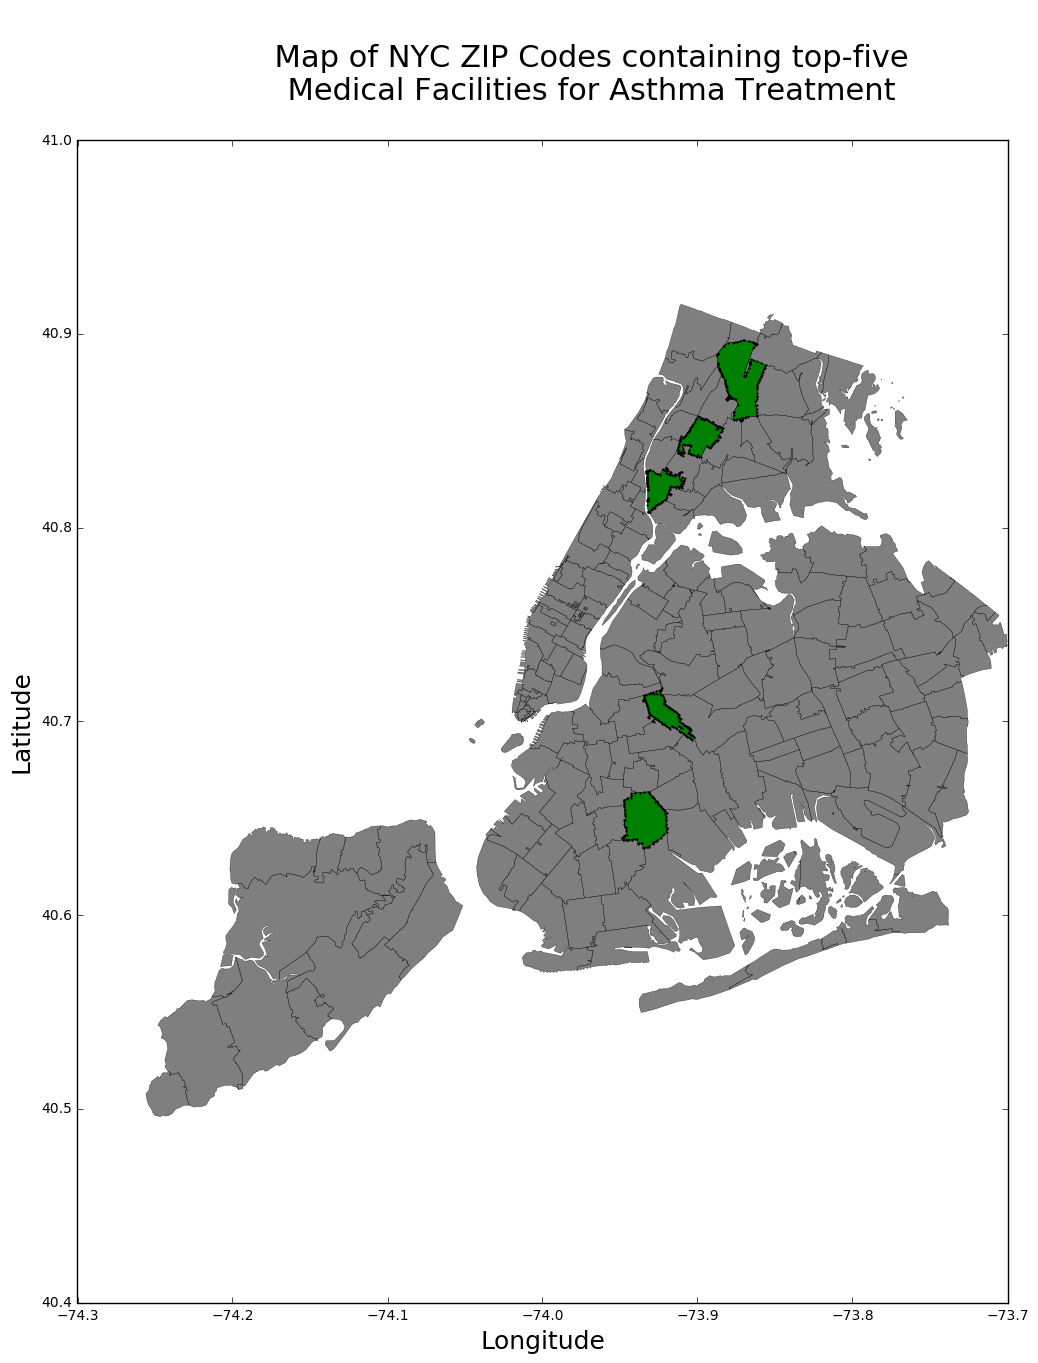

In [16]:
fig_1, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(12, 15))
zipcodes_t5.plot(ax=ax1, color='k', alpha=0.5, linewidth=0.2)
facilities_shape.plot(ax=ax1, marker='o',color='g', 
                      markersize=1, legend=True, 
                      linewidth=0.2, alpha=1)
plt.title(
          '''
          Map of NYC ZIP Codes containing top-five
          Medical Facilities for Asthma Treatment
          ''', 
          fontsize=22
          )
plt.ylabel('Latitude', fontsize=18)
plt.xlabel('Longitude', fontsize=18)

**TASK 2 STEP 2 COMPLETE: Plot chloropleth map of NYC ZIP Codes by Highway Mileage**

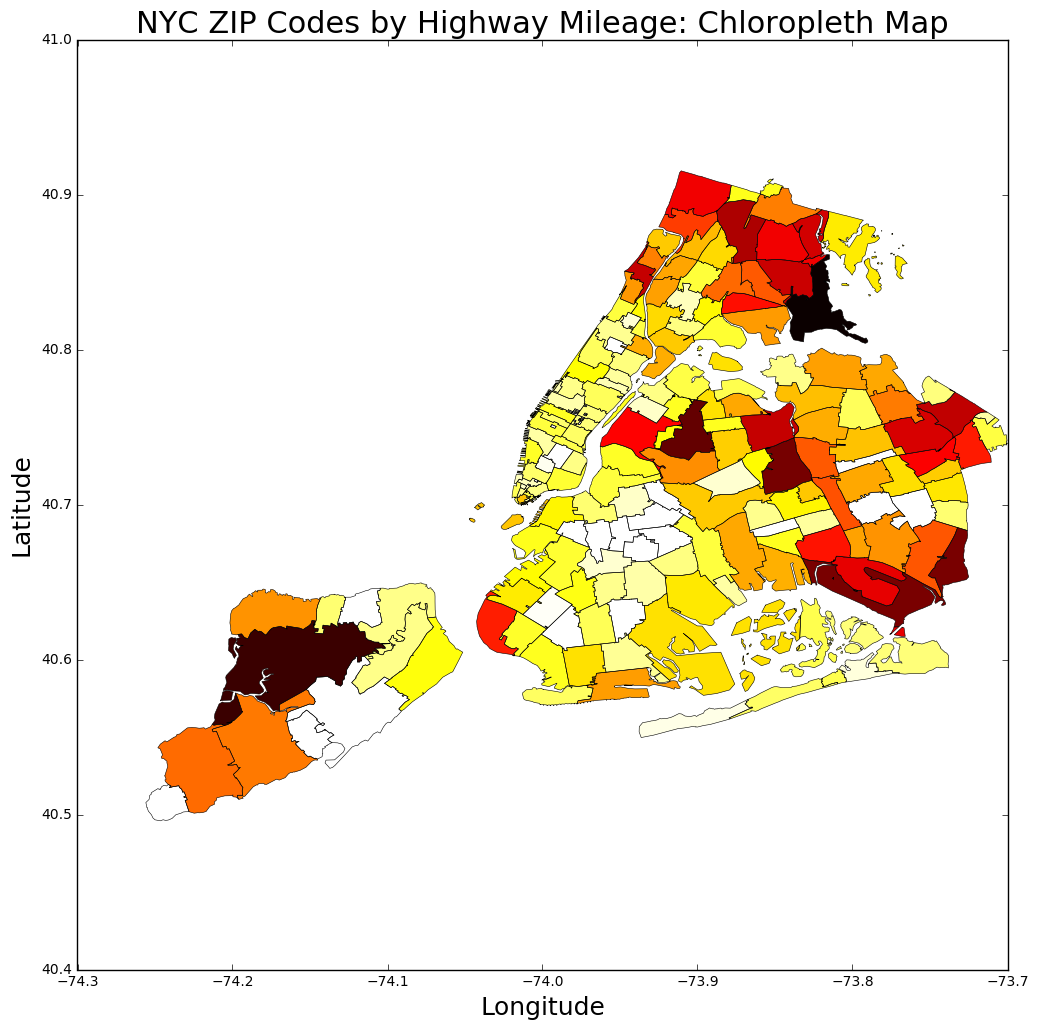

In [17]:
fig_2 = zipcodes_t5.plot('highway_length', cmap='hot_r', 
                alpha=1,linewidth=0.4, figsize=(12, 15)
               )
plt.title("NYC ZIP Codes by Highway Mileage: Chloropleth Map", fontsize=22)
plt.ylabel('Latitude', fontsize=18)
plt.xlabel('Longitude', fontsize=18)

**Now grab and munge data for NYC Police Precincts & Murders**

In [18]:
precinctsQuery = '''
SELECT *
FROM fk759.nypd_precincts
'''
precinctsStream = queryCartoDB(precinctsQuery, format='GeoJSON')
precinctsData   = json.loads(precinctsStream.read())
precincts       = gp.GeoDataFrame.from_features(
                  precinctsData['features'])
precincts       = precincts.sort(['precinct'], ascending=[1])
precincts.drop('cartodb_id', axis=1, inplace=True)
precincts.head(5)

C:\Users\fbk\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:9: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,geometry,precinct,shape_area,shape_leng
0,"(POLYGON ((-74.04387800000001 40.690188, -74.0...",001,4.718491e+07,79992.926375
48,"(POLYGON ((-73.988643 40.722934, -73.988687 40...",005,1.808769e+07,18674.673547
49,"(POLYGON ((-73.999684 40.738552, -73.996840000...",006,2.212938e+07,27182.337851
50,"(POLYGON ((-73.97345300000001 40.718963, -73.9...",007,1.836225e+07,17293.251594
51,"(POLYGON ((-73.971609 40.726723, -73.971627 40...",009,2.139672e+07,19773.163480


In [19]:
murdersQuery = '''
SELECT *
FROM fk759.nyc_felonies
WHERE offense ILIKE '%MURDER%'
'''
murdersStream = queryCartoDB(murdersQuery, format='GeoJSON')
murdersData   = json.loads(murdersStream.read())
murders_1     = gp.GeoDataFrame.from_features(murdersData['features'])
murders_1.crs = from_epsg(2263)
murders_1     = murders_1.sort(['precinct'], ascending=[1])
murders_1.rename(columns={'the_geom':'geometry'}, inplace=True)
murders       = murders_1[['identifier', 'occurrencedate', 
                    'compstatday', 'compstatmonth', 
                    'compstatyear', 'offense', 
                    'precinct', 'borough' 
                    ]]

murders.crs    = from_epsg(2263)
murders_points = murders_1[['identifier', 'occurrencedate', 
                    'compstatday', 'compstatmonth', 
                    'compstatyear', 'offense', 
                    'precinct', 'borough', 
                    'latitude', 'longitude', 'geometry' 
                    ]]
murders_points = gp.GeoDataFrame(murders_points)
murders_points.crs = from_epsg(2263)
murders.head()

C:\Users\fbk\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,identifier,occurrencedate,compstatday,compstatmonth,compstatyear,offense,precinct,borough
208,201589787727190,2015-08-21T17:07:00Z,21,Aug,2015,MURDER,001,Manhattan
252,201589787727357,2015-09-26T05:43:00Z,26,Sep,2015,MURDER,005,Manhattan
220,201589787727257,2015-08-28T22:00:00Z,28,Aug,2015,MURDER,007,Manhattan
65,987726368,2015-02-23T16:39:00Z,23,Feb,2015,MURDER,009,Manhattan
45,987726273,2015-01-25T14:43:00Z,25,Jan,2015,MURDER,013,Manhattan


In [20]:
#There were 257 murders in New York City during 2015
murders.count()

identifier        257
occurrencedate    257
compstatday       257
compstatmonth     257
compstatyear      257
offense           257
precinct          257
borough           257
dtype: int64

In [21]:
#There are currently 77 NYPD police precincts in New York City
precincts.count()

geometry      76
precinct      76
shape_area    76
shape_leng    76
dtype: int64

**Now merge Precinct and Murder dataframes prior to making Chloropleth Map of Precincts indexed by Murder Rate**

In [22]:
mp_merge     = pd.merge(murders, precincts, left_on=
                        ['precinct'], right_on=['precinct'], 
                        how='outer')
mp_merge     = mp_merge[np.isfinite(mp_merge['compstatday'])]
mp_merge     = gp.GeoDataFrame(mp_merge)
mp_merge.crs = from_epsg(2263)
mp_merge.head(5)

,identifier,occurrencedate,compstatday,compstatmonth,compstatyear,offense,precinct,borough,geometry,shape_area,shape_leng
0,2.015898e+14,2015-08-21T17:07:00Z,21.0,Aug,2015.0,MURDER,001,Manhattan,"(POLYGON ((-74.04387800000001 40.690188, -74.0...",4.718491e+07,79992.926375
1,2.015898e+14,2015-09-26T05:43:00Z,26.0,Sep,2015.0,MURDER,005,Manhattan,"(POLYGON ((-73.988643 40.722934, -73.988687 40...",1.808769e+07,18674.673547
2,2.015898e+14,2015-08-28T22:00:00Z,28.0,Aug,2015.0,MURDER,007,Manhattan,"(POLYGON ((-73.97345300000001 40.718963, -73.9...",1.836225e+07,17293.251594
3,9.877264e+08,2015-02-23T16:39:00Z,23.0,Feb,2015.0,MURDER,009,Manhattan,"(POLYGON ((-73.971609 40.726723, -73.971627 40...",2.139672e+07,19773.163480
4,9.877263e+08,2015-01-25T14:43:00Z,25.0,Jan,2015.0,MURDER,013,Manhattan,"(POLYGON ((-73.98156 40.743882, -73.9799589999...",2.950784e+07,27734.304550


In [23]:
murders_points.head()

,identifier,occurrencedate,compstatday,compstatmonth,compstatyear,offense,precinct,borough,latitude,longitude,geometry
208,201589787727190,2015-08-21T17:07:00Z,21,Aug,2015,MURDER,001,Manhattan,40.728251,-74.005374,POINT (-74.005374 40.728251)
252,201589787727357,2015-09-26T05:43:00Z,26,Sep,2015,MURDER,005,Manhattan,40.709984,-73.996441,POINT (-73.996441 40.709984)
220,201589787727257,2015-08-28T22:00:00Z,28,Aug,2015,MURDER,007,Manhattan,40.718564,-73.988201,POINT (-73.988201 40.718564)
65,987726368,2015-02-23T16:39:00Z,23,Feb,2015,MURDER,009,Manhattan,40.720813,-73.978136,POINT (-73.97813600000001 40.720813)
45,987726273,2015-01-25T14:43:00Z,25,Jan,2015,MURDER,013,Manhattan,40.742238,-73.991193,POINT (-73.991193 40.742238)


In [24]:
'''
This cell will give us the murder count of each precinct in 2015.
'''
mp_merge_2   = mp_merge.groupby('precinct').precinct.count()
mp_merge_2_1 = pd.DataFrame(data=mp_merge_2.index, columns=['precinct'])
mp_merge_2_2 = pd.DataFrame(data=mp_merge_2.values, columns=['murder_count'])
mp_merge_2   = pd.merge(mp_merge_2_1, mp_merge_2_2, left_index=True, right_index=True)
mp_merge_2.head(10)

,precinct,murder_count
0,001,1
1,005,1
2,007,1
3,009,1
4,013,1
5,014,6
6,017,1
7,019,1
8,023,7
9,024,1


In [25]:
'''
And finally, we will join the murder count back onto the 
original precincts geodataframe.
'''
precincts_murders = pd.merge(precincts, mp_merge_2, left_on=
                    ['precinct'], right_on=['precinct'], 
                    how='outer')
precincts_murders = precincts_murders.fillna(0)
precincts_murders['murder_count'] = precincts_murders['murder_count'].astype(int)
precincts_murders = gp.GeoDataFrame(precincts_murders)
precincts_murders.crs = from_epsg(2263)
precincts_murders.head(10)

,geometry,precinct,shape_area,shape_leng,murder_count
0,"(POLYGON ((-74.04387800000001 40.690188, -74.0...",001,4.718491e+07,79992.926375,1
1,"(POLYGON ((-73.988643 40.722934, -73.988687 40...",005,1.808769e+07,18674.673547,1
2,"(POLYGON ((-73.999684 40.738552, -73.996840000...",006,2.212938e+07,27182.337851,0
3,"(POLYGON ((-73.97345300000001 40.718963, -73.9...",007,1.836225e+07,17293.251594,1
4,"(POLYGON ((-73.971609 40.726723, -73.971627 40...",009,2.139672e+07,19773.163480,1
5,"(POLYGON ((-74.001386 40.76285, -74.000512 40....",010,2.723015e+07,40123.540824,0
6,"(POLYGON ((-73.98156 40.743882, -73.9799589999...",013,2.950784e+07,27734.304550,1
7,"(POLYGON ((-73.974648 40.753367, -73.975103 40...",014,2.049701e+07,20974.961222,6
8,"(POLYGON ((-73.964212 40.746604, -73.964274 40...",017,2.227068e+07,24579.941395,1
9,"(POLYGON ((-73.99393600000001 40.77318, -73.99...",018,3.229352e+07,42180.021256,0


**Plot Murders by Precinct Chloropleth Map**

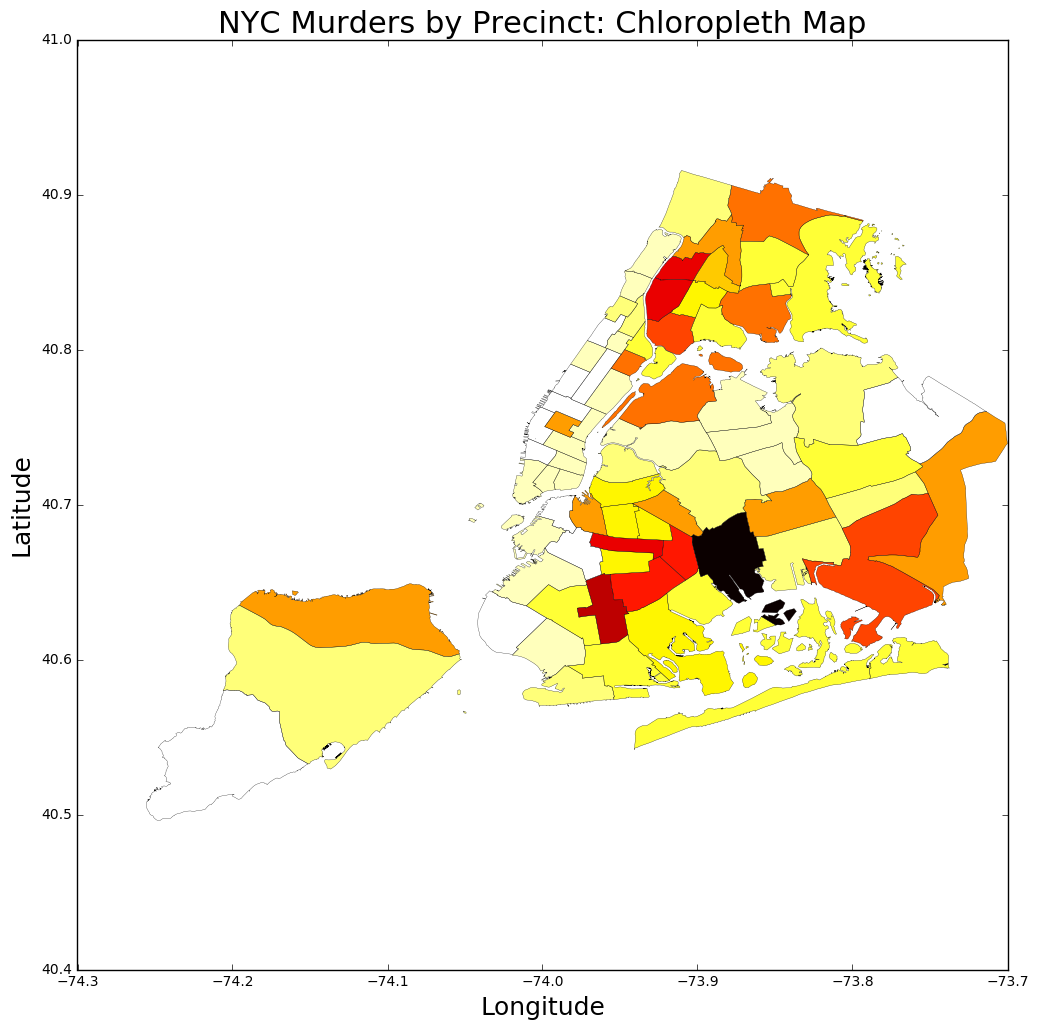

In [26]:
fig_3 = precincts_murders.plot('murder_count', cmap='hot_r', 
                alpha=1,linewidth=0.2, figsize=(12, 15))
plt.title("NYC Murders by Precinct: Chloropleth Map", fontsize=22)
plt.ylabel('Latitude', fontsize=18)
plt.xlabel('Longitude', fontsize=18)

**Merge Murder Data with ZIP Code Geospatial Data**

In [27]:
zip_murders = gp.sjoin(zipcodes, murders_points, how="left", op='intersects')
zip_murders.head(5)

,zipcode,geometry,highway_length,index_right,identifier,occurrencedate,compstatday,compstatmonth,compstatyear,offense,precinct,borough,latitude,longitude
0,10154,"(POLYGON ((-73.971451 40.757749, -73.971907 40...",0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10119,"(POLYGON ((-73.994844 40.750293, -73.994328999...",0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10069,"(POLYGON ((-73.987291 40.77877, -73.9874570000...",2.015478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11428,"(POLYGON ((-73.74076700000001 40.727263, -73.7...",8.349350,93.0,9.877265e+08,2015-04-16T16:20:00Z,16.0,Apr,2015.0,MURDER,105,Queens,40.726187,-73.735234
3,11428,"(POLYGON ((-73.74076700000001 40.727263, -73.7...",8.349350,195.0,2.015898e+14,2015-08-05T01:19:00Z,5.0,Aug,2015.0,MURDER,105,Queens,40.715544,-73.747765


In [28]:
'''
This cell will give us the murder count of each NYC ZIP code in 2015.
'''

zip_murders_agg   = zip_murders.groupby('zipcode').zipcode.count()
zip_murders_agg_1 = pd.DataFrame(zip_murders_agg.index, columns=['zipcode'])
zip_murders_agg_2 = pd.DataFrame(zip_murders_agg.values, columns=['murder_count'])
zip_murders_agg   = pd.merge(zip_murders_agg_1, zip_murders_agg_2, left_index=True, right_index=True)
zip_murders_agg.tail(5)

,zipcode,murder_count
195,11691,3
196,11692,1
197,11693,2
198,11694,1
199,11697,1


In [29]:
zip_murders_agg = pd.merge(zip_murders, zip_murders_agg, left_on=
                    ['zipcode'], right_on=['zipcode'], 
                    how='outer')
zip_murders_agg = zip_murders_agg.fillna(0)
zip_murders_agg['murder_count'] = zip_murders_agg['murder_count'].astype(int)
zip_murders_agg = gp.GeoDataFrame(zip_murders_agg)
zip_murders_agg.crs = from_epsg(2263)
zip_murders_agg

,zipcode,geometry,highway_length,index_right,identifier,occurrencedate,compstatday,compstatmonth,compstatyear,offense,precinct,borough,latitude,longitude,murder_count
0,10154,"(POLYGON ((-73.971451 40.757749, -73.971907 40...",0.000000,0.0,0.000000e+00,0,0.0,0,0.0,0,0,0,0.000000,0.000000,1
1,10119,"(POLYGON ((-73.994844 40.750293, -73.994328999...",0.000000,0.0,0.000000e+00,0,0.0,0,0.0,0,0,0,0.000000,0.000000,1
2,10069,"(POLYGON ((-73.987291 40.77877, -73.9874570000...",2.015478,0.0,0.000000e+00,0,0.0,0,0.0,0,0,0,0.000000,0.000000,1
3,11428,"(POLYGON ((-73.74076700000001 40.727263, -73.7...",8.349350,93.0,9.877265e+08,2015-04-16T16:20:00Z,16.0,Apr,2015.0,MURDER,105,Queens,40.726187,-73.735234,2
4,11428,"(POLYGON ((-73.74076700000001 40.727263, -73.7...",8.349350,195.0,2.015898e+14,2015-08-05T01:19:00Z,5.0,Aug,2015.0,MURDER,105,Queens,40.715544,-73.747765,2
5,11374,"(POLYGON ((-73.85087900000001 40.72873, -73.85...",6.551638,0.0,0.000000e+00,0,0.0,0,0.0,0,0,0,0.000000,0.000000,1
6,11102,"(POLYGON ((-73.917695 40.767357, -73.918493 40...",3.085684,31.0,9.877262e+08,2015-01-12T15:28:00Z,12.0,Jan,2015.0,MURDER,114,Queens,40.772777,-73.925508,4
7,11102,"(POLYGON ((-73.917695 40.767357, -73.918493 40...",3.085684,221.0,2.015898e+14,2015-08-29T05:00:00Z,29.0,Aug,2015.0,MURDER,114,Queens,40.772876,-73.930025,4
8,11102,"(POLYGON ((-73.917695 40.767357, -73.918493 40...",3.085684,154.0,9.877268e+08,2015-06-20T06:20:00Z,20.0,Jun,2015.0,MURDER,114,Queens,40.769265,-73.933086,4
9,11102,"(POLYGON ((-73.917695 40.767357, -73.918493 40...",3.085684,51.0,9.877263e+08,2015-01-31T14:30:00Z,31.0,Jan,2015.0,MURDER,114,Queens,40.778464,-73.921396,4


**TASK 3 STEP 1 COMPLETE: Produce Dataframe with Murder Count for ZIP Codes with Top-5 Facilities for Asthma-related Treatment**

In [30]:
zip_murders_t5    = zip_murders_agg.groupby('zipcode').precinct.count()
zip_murders_t5_m1 = pd.DataFrame(data=zip_murders_t5.index, 
                                 columns=['zipcode'])
zip_murders_t5_m2 = pd.DataFrame(data=zip_murders_t5.values, 
                                 columns=['murder_count'])
zip_murders_t5    = pd.merge(zip_murders_t5_m1, zip_murders_t5_m2, 
                             left_index=True, right_index=True)
zip_murders_t5    = zip_murders_t5[zip_murders_t5['zipcode'].isin(
                                [10467, 10451, 10457, 11203, 11237])]
zip_murders_t5

,zipcode,murder_count
77,10451,5
83,10457,7
93,10467,2
111,11203,5
144,11237,5


**TASK 3 STEP 2 COMPLETE: Plot Murders by ZIP Code Chloropleth Map**

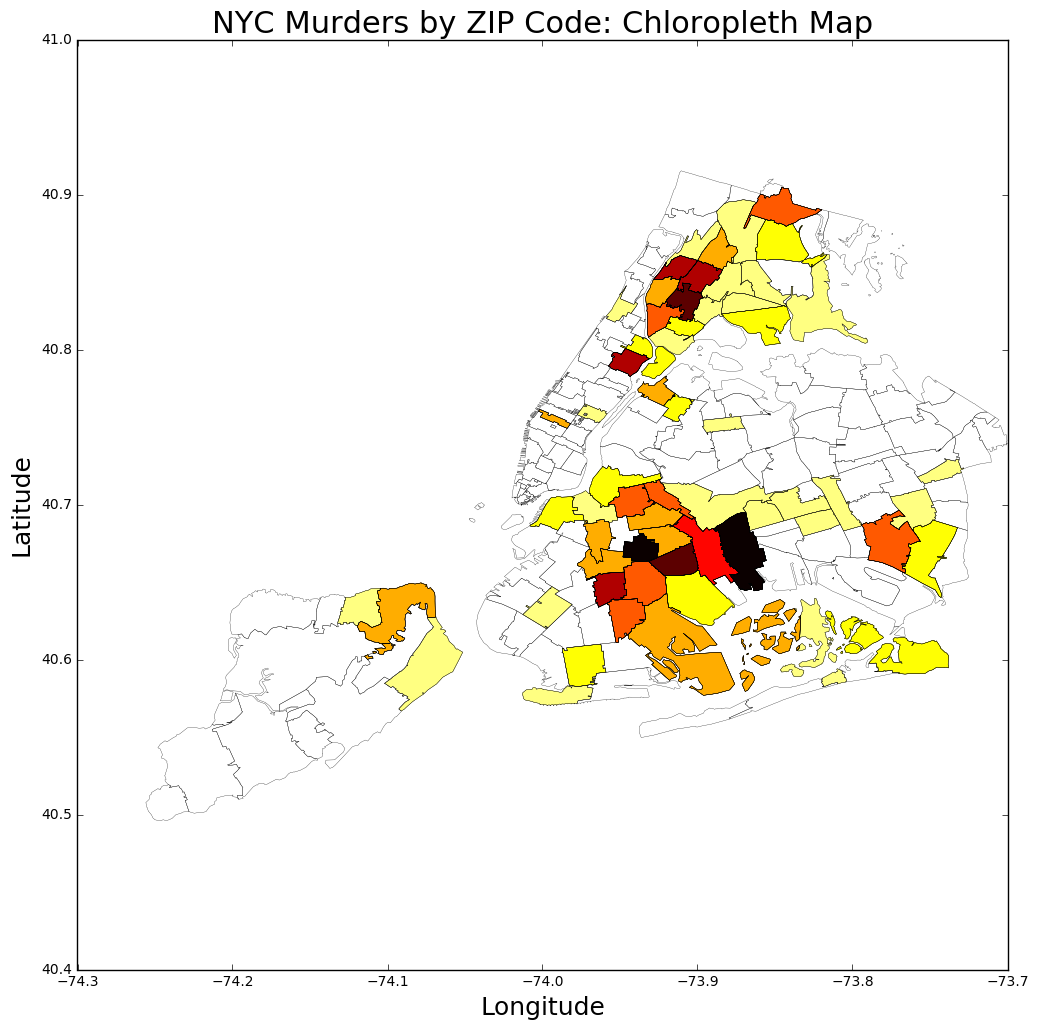

In [31]:
fig_4 = zip_murders_agg.plot('murder_count', cmap='hot_r', 
                alpha=1,linewidth=0.2, figsize=(12, 15))
plt.title("NYC Murders by ZIP Code: Chloropleth Map", fontsize=22)
plt.ylabel('Latitude', fontsize=18)
plt.xlabel('Longitude', fontsize=18)

In [32]:
zip_murders_reg = zip_murders_agg[zip_murders_agg['zipcode'].isin(
                                [10467, 10451, 10457, 11203, 11237])]
zip_murders_reg.drop(['index_right', 'identifier', 
                      'occurrencedate', 'compstatday', 
                      'compstatmonth', 'compstatyear',  
                      'offense', 'borough', 'geometry',
                      'geometry', 'precinct',
                      'latitude', 'longitude'], axis=1, inplace=True)
zip_murders_reg.drop_duplicates()

C:\Users\fbk\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,zipcode,highway_length,murder_count
13,10457,5.017199,7
204,10467,19.172015,2
223,10451,7.914185,5
334,11237,0.000000,5
342,11203,2.212840,5


**TASK 6 Executed Below**

In [33]:
X = zip_murders_reg[['murder_count', 'highway_length']]
y = zip_murders_reg['zipcode']

## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                zipcode   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     133.3
Date:                Sat, 31 Dec 2016   Prob (F-statistic):           1.17e-12
Time:                        08:40:13   Log-Likelihood:                -145.01
No. Observations:                  24   AIC:                             296.0
Df Residuals:                      21   BIC:                             299.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
const            1.24e+04    122.597    101.171      0.000      1.21e+04  1.27e+04
murder_count    -224.9510     19.513    -11.528      0.000      -265.531  -184.371
highway_length   -82.9626      5.212    -15.916      0.000       -93.802   -72.123
==============================================================================
Omnibus:                        3.665   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                2.564
Skew:                          -0.636   Prob(JB):                        0.278
Kurtosis:                       2.027   Cond. No.                         46.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

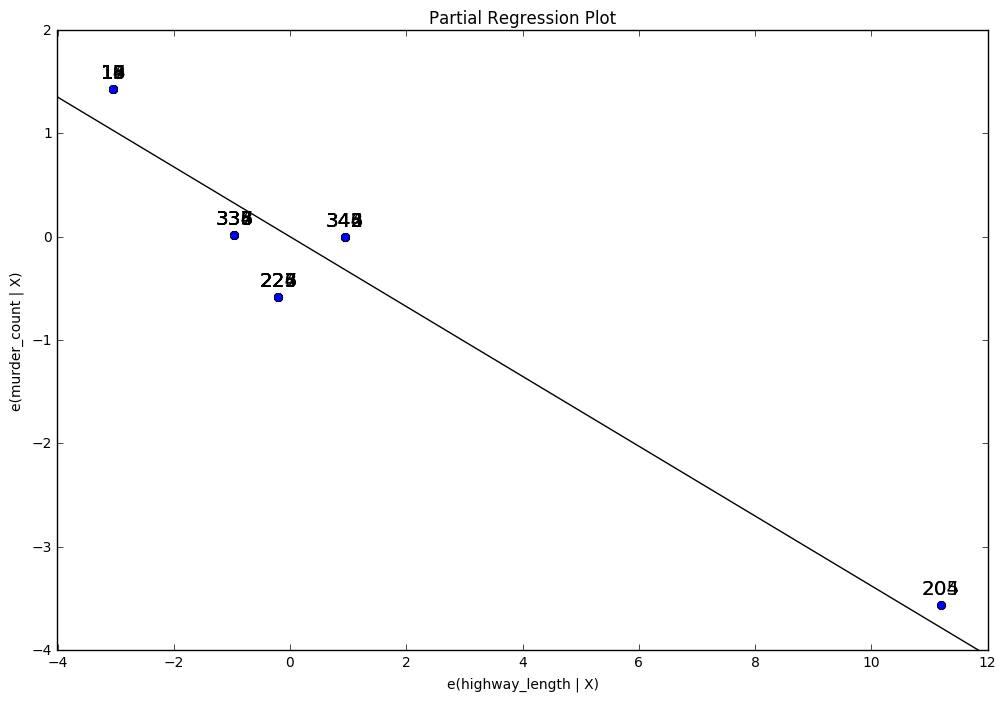

In [34]:
'''
TASK 6 Analysis: According to the regression analysis, the murder rate decreases
                 as highway length increases.
'''
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.plot_partregress("murder_count", "highway_length", ["zipcode"], data=zip_murders_reg, ax=ax)

**Begin to Whiten Data for Clustering**

In [35]:
zip_murders_clus     = zip_murders_agg[['zipcode', 'highway_length', 'murder_count']]
zip_murders_clus_hwy = zip_murders_clus.sort(['highway_length'], ascending=[1])
zip_murders_clus_hwy.tail(1)

C:\Users\fbk\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,zipcode,highway_length,murder_count
217,10465,25.339762,2


In [36]:
zip_murders_clus_murd = zip_murders_clus.sort(['murder_count'], ascending=[1])
zip_murders_clus_murd.tail(1)

C:\Users\fbk\Anaconda2\envs\py27\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,zipcode,highway_length,murder_count
181,11213,0.0,9


**Use K-means Clustering Method to find Clusters of NYC ZIP codes by Asthma Risk**

'''
Develop asthma index by dividing each ZIP highway mileage and murder count 
by the maximum of any ZIP code (25.339762 miles and 9 murders respectively) 
and then adding the results to develop index for asthma risk.
'''
zip_asthma_clus_1 = zip_murders_agg[['zipcode', 'geometry', 'highway_length', 'murder_count']]
zip_asthma_clus_1['asthma_index'] = (zip_asthma_clus_1['highway_length'] / 25.339762) + (zip_asthma_clus_1['murder_count'] / 9)
zip_asthma_clus = zip_asthma_clus_1[['zipcode', 'asthma_index']]
zip_asthma_clus = zip_asthma_clus.drop_duplicates('zipcode', take_last=True)
zip_asthma_clus.head()

**TASK 7 Executed Below**

In [ ]:
'''
As a note, majority of the code from below two cells altered with original work
by Jordan Vani, CUSP student with Github username: PUI2016_jmv423

Original author's file may be found at URL:
https://github.com/jvani/PUI2016_jmv423/blob/master/HW11_jmv423/Assignment2_jmv423.ipynb
'''

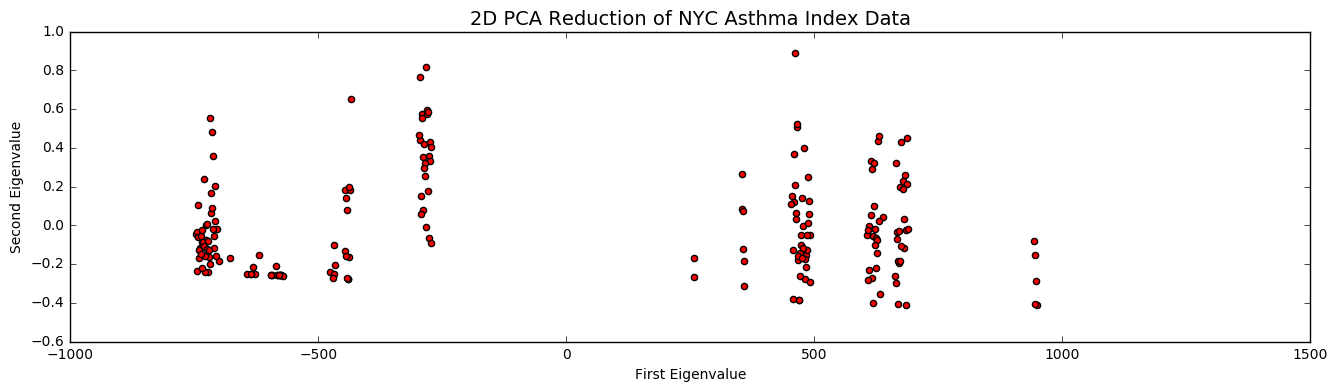

In [38]:
n=2
pca = PCA(n)
Xproj = pca.fit_transform(zip_asthma_clus)
Xproj_df = pd.DataFrame(Xproj)
eigenvalues = pca.explained_variance_

fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
ax.scatter(Xproj[:, 0], Xproj[:, 1], c='r')
ax.set_xlabel('First Eigenvalue')
ax.set_ylabel('Second Eigenvalue')
ax.set_title('2D PCA Reduction of NYC Asthma Index Data',
             fontsize=14)

In [39]:
X = zip_asthma_clus
range_n_clusters = range(2,3)
for n_clusters in range_n_clusters:
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters = {}".format(n_clusters) 
          + " the avg. silhouette_score is:{}".format(silhouette_avg.round(3)))

For n_clusters = 2 the avg. silhouette_score is:0.838
